In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from utils.clean import text_to_wordlist
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train = train.dropna()
test = test.dropna()

In [4]:
train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [5]:
test.__len__()

3563466

In [6]:
from utils.features import generate_qid

Before anythign else let's generate some ids for our questions to study later on their frequency

In [7]:
%%time
test = generate_qid(df=test)

CPU times: user 12 s, sys: 453 ms, total: 12.5 s
Wall time: 12.5 s


In [6]:
# split_size = 1000
# train = pd.concat([ train[train['is_duplicate'] == 1][:split_size], train[train['is_duplicate'] == 0][:split_size]])

In [8]:
train[:5]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
test[:5]

,test_id,question1,question2,qid1,qid2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,2447329,3861609
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,2686201,2627256
2,2,What but is the best way to send money from Ch...,What you send money to China?,3479610,3169183
3,3,Which food not emulsifiers?,What foods fibre?,3738446,2245807
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,4059625,320692


![Similarity](https://miro.medium.com/max/926/1*u2ZZPh5er5YbmOg7k-s0-A.png)

### Drop the empty rows

In [10]:
train.drop(train.loc[train['question1'] == ' '].index,inplace=True)
train.drop(train.loc[train['question2'] == ' '].index,inplace=True)
test.drop(test.loc[test['question1'] == ' '].index,inplace=True)
test.drop(test.loc[test['question2'] == ' '].index,inplace=True)

### Lowecase and clean them

In [11]:
%%time
train['question1'] = train['question1'].apply(lambda x: text_to_wordlist(text=x))
train['question2'] = train['question2'].apply(lambda x: text_to_wordlist(text=x))
test['question1'] = test['question1'].apply(lambda x: text_to_wordlist(text=x))
test['question2'] = test['question2'].apply(lambda x: text_to_wordlist(text=x))

CPU times: user 5min 4s, sys: 1.54 s, total: 5min 6s
Wall time: 5min 7s


### Let's find some features

**Sources:**
* [ishritam/Quora-question-pair-similarity](https://github.com/ishritam/Quora-question-pair-similarity/blob/master/Quora%20Case%20Study.ipynb)
* [Finding Similar Quora Questions with Word2Vec and Xgboost](https://towardsdatascience.com/finding-similar-quora-questions-with-word2vec-and-xgboost-1a19ad272c0d)
* [Word2vec & Xgboost](https://github.com/susanli2016/NLP-with-Python/blob/master/Word2vec_xgboost.ipynb)
* [LSTM with Glove](https://www.kaggle.com/amoyyean/lstm-with-glove)
* [Data Analysis & XGBoost Starter](https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb)
* [Finding similar documents with Word2Vec and WMD](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/WMD_tutorial.ipynb)

**Features:**
* freq_qid1 : Frequency of qid1's
* freq_qid2 : Frequency of qid2's
* q1len : Length of q1
* q2len : Length of q2
* q1_n_words : Number of words in Question 1
* q2_n_words : Number of words in Question 2
* word_Common : (Number of common unique words in Question 1 and Question 2)
* word_Total : (Total num of words in Question 1 + Total num of words in Question 2)
* word_share : (word_common)/(word_Total)
* freq_q1+freq_q2 : sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 : absolute difference of frequency of qid1 and qid2
* cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
* cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
* csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
* csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 
* ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2 
* ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2 
* last_word_eq : Check if First word of both questions is equal or not 
* first_word_eq : Check if First word of both questions is equal or not 
* abs_len_diff : Abs. length difference
* mean_len : Average Token Length of both Questions 
* fuzz_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* fuzz_partial_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* token_sort_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* token_set_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
* wmd: Word Mover’s Distance between two document
* jaccard: Similarity Distance

In [13]:
from utils.features import fast_features,fuzzy_features,token_features

In [14]:
%%time
train = fast_features(df=train)

CPU times: user 47.5 s, sys: 520 ms, total: 48 s
Wall time: 48.2 s


In [15]:
%%time
test = fast_features(df=test)

CPU times: user 6min 57s, sys: 4.58 s, total: 7min 2s
Wall time: 7min 3s


In [16]:
%%time
train = token_features(df=train)

CPU times: user 4min 55s, sys: 1.74 s, total: 4min 57s
Wall time: 4min 58s


In [17]:
%%time
test = token_features(df=test)

CPU times: user 43min 13s, sys: 23 s, total: 43min 36s
Wall time: 43min 48s


In [18]:
%%time
train = fuzzy_features(df=train)

CPU times: user 2min 25s, sys: 2.49 s, total: 2min 27s
Wall time: 2min 29s


In [19]:
%%time
test = fuzzy_features(df=test)

CPU times: user 21min 23s, sys: 20.9 s, total: 21min 44s
Wall time: 21min 51s


In [20]:
train[:5]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,0.982759,100,93,93,100
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0,4,1,53,90,...,0.470585,0.0,1.0,5.0,14.5,0.611111,86,63,67,75
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,0.166667,66,66,54,54
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0,1,1,49,62,...,0.000000,0.0,0.0,3.0,12.5,0.040000,36,36,35,39
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,74,39,...,0.307690,0.0,1.0,6.0,10.0,0.175000,67,47,45,56


In [21]:
test[:5]

,test_id,question1,question2,qid1,qid2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,2447329,3861609,1,1,57,68,12,...,0.214284,0.0,0.0,3.0,12.5,0.241379,58,55,46,46
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require,2686201,2627256,1,1,65,43,15,...,0.357140,0.0,0.0,7.0,10.5,0.386364,82,58,49,58
2,2,what but is the best way to send money from ch...,what you send money to china,3479610,3169183,1,1,60,29,15,...,0.357140,0.0,1.0,8.0,10.0,0.400000,92,55,60,83
3,3,which food not emulsifiers,what foods fibre,3738446,2245807,1,1,27,17,5,...,0.000000,0.0,0.0,1.0,3.5,0.277778,52,52,52,53
4,4,how aberystwyth start reading,how their can i start reading,4059625,320692,1,1,30,30,5,...,0.499992,1.0,1.0,2.0,5.0,0.483871,74,66,69,70


In [22]:
from utils.features import glove_wmd, jaccard, min_max_scalling

**Sources:**

* [WMD Tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/WMD_tutorial.ipynb)
* [WMD](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.wmdistance.html)
 
***Word Mover’s Distance between two documents***

**Differences between Jaccard Similarity and Cosine Similarity:**
* Jaccard similarity takes only unique set of words for each sentence / document while cosine similarity takes total length of the vectors. (these vectors could be made from bag of words term frequency or tf-idf)
* This means that if you repeat the word “friend” in Sentence 1 several times, cosine similarity changes but Jaccard similarity does not. For ex, if the word “friend” is repeated in the first sentence 50 times, cosine similarity drops to 0.4 but Jaccard similarity remains at 0.5.
* Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity. For two product descriptions, it will be better to use Jaccard similarity as repetition of a word does not reduce their similarity.

In [23]:
%%time
train = glove_wmd(df=train)

CPU times: user 5min 41s, sys: 2.85 s, total: 5min 44s
Wall time: 5min 46s


In [24]:
%%time
test = glove_wmd(df=test)

CPU times: user 45min 11s, sys: 13.5 s, total: 45min 24s
Wall time: 45min 28s


In [25]:
%%time
train = jaccard(df=train)

CPU times: user 12.3 s, sys: 203 ms, total: 12.5 s
Wall time: 12.5 s


In [26]:
%%time
test = jaccard(df=test)

CPU times: user 1min 45s, sys: 2.17 s, total: 1min 47s
Wall time: 1min 47s


In [27]:
to_be_scaled = [
    'freq_q1+q2',
    'freq_q1-q2',
    'freq_qid1',
    'freq_qid2',
    'q1_n_words',
    'q2_n_words',
    'word_Common',
    'word_Total',
    'last_word_eq',
    'first_word_eq',
    'abs_len_diff',
    'mean_len',
    'q1len',
    'q2len',
    'fuzz_partial_ratio',
    'token_set_ratio',
    'token_sort_ratio',
    'fuzz_ratio',
]

In [28]:
%%time
train = min_max_scalling(df=train,columns=to_be_scaled)

CPU times: user 1.1 s, sys: 164 ms, total: 1.26 s
Wall time: 1.26 s


In [29]:
%%time
test = min_max_scalling(df=test,columns=to_be_scaled)

CPU times: user 8.85 s, sys: 2.45 s, total: 11.3 s
Wall time: 11.3 s


In [30]:
train[:5]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,wmd,jaccard
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.000000,0.0,0.107084,0.049209,...,1.0,0.008772,0.093863,0.982759,1.00,0.93,0.93,1.00,0.147856,0.916667
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0,0.061224,0.0,0.085667,0.078207,...,1.0,0.021930,0.104693,0.611111,0.86,0.63,0.67,0.75,0.554370,0.444444
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.000000,0.0,0.118616,0.050967,...,1.0,0.017544,0.086643,0.166667,0.66,0.66,0.54,0.54,0.562440,0.200000
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0,0.000000,0.0,0.079077,0.053603,...,0.0,0.013158,0.090253,0.040000,0.36,0.36,0.35,0.39,1.184910,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.040816,0.0,0.120264,0.033392,...,1.0,0.026316,0.072202,0.175000,0.67,0.47,0.45,0.56,0.795780,0.250000


In [39]:
train.to_csv('data/train_clean.csv',index=False)

In [40]:
test.to_csv('data/test_clean.csv',index=False)

In [31]:
features_list = train.columns.tolist()[6:]
features_list

['freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'longest_substr_ratio',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'wmd',
 'jaccard']

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train[features_list], train['is_duplicate'], test_size=0.33, random_state=42,stratify=train['is_duplicate'])

In [34]:
import xgboost as xgb

# Set our parameters for xgboost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.02,
    'max_depth': 4,
    }

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68448	test-logloss:0.68478
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.61607	test-logloss:0.61606
[20]	train-logloss:0.56617	test-logloss:0.56602
[30]	train-logloss:0.52820	test-logloss:0.52830
[40]	train-logloss:0.49920	test-logloss:0.49921
[50]	train-logloss:0.47696	test-logloss:0.47686
[60]	train-logloss:0.45919	test-logloss:0.45914
[70]	train-logloss:0.44477	test-logloss:0.44510
[80]	train-logloss:0.43323	test-logloss:0.43351
[90]	train-logloss:0.42371	test-logloss:0.42430
[100]	train-logloss:0.41608	test-logloss:0.41673
[110]	train-logloss:0.40958	test-logloss:0.41046
[120]	train-logloss:0.40434	test-logloss:0.40521
[130]	train-logloss:0.39994	test-logloss:0.40085
[140]	train-logloss:0.39614	test-logloss:0.39720
[150]	train-logloss:0.39282	test-logloss:0.39404
[160]	train-logloss:0.39020	test-logloss:0.39132
[170]	train-logloss:0.38760	t

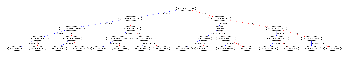

In [35]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 100]
plt.show()

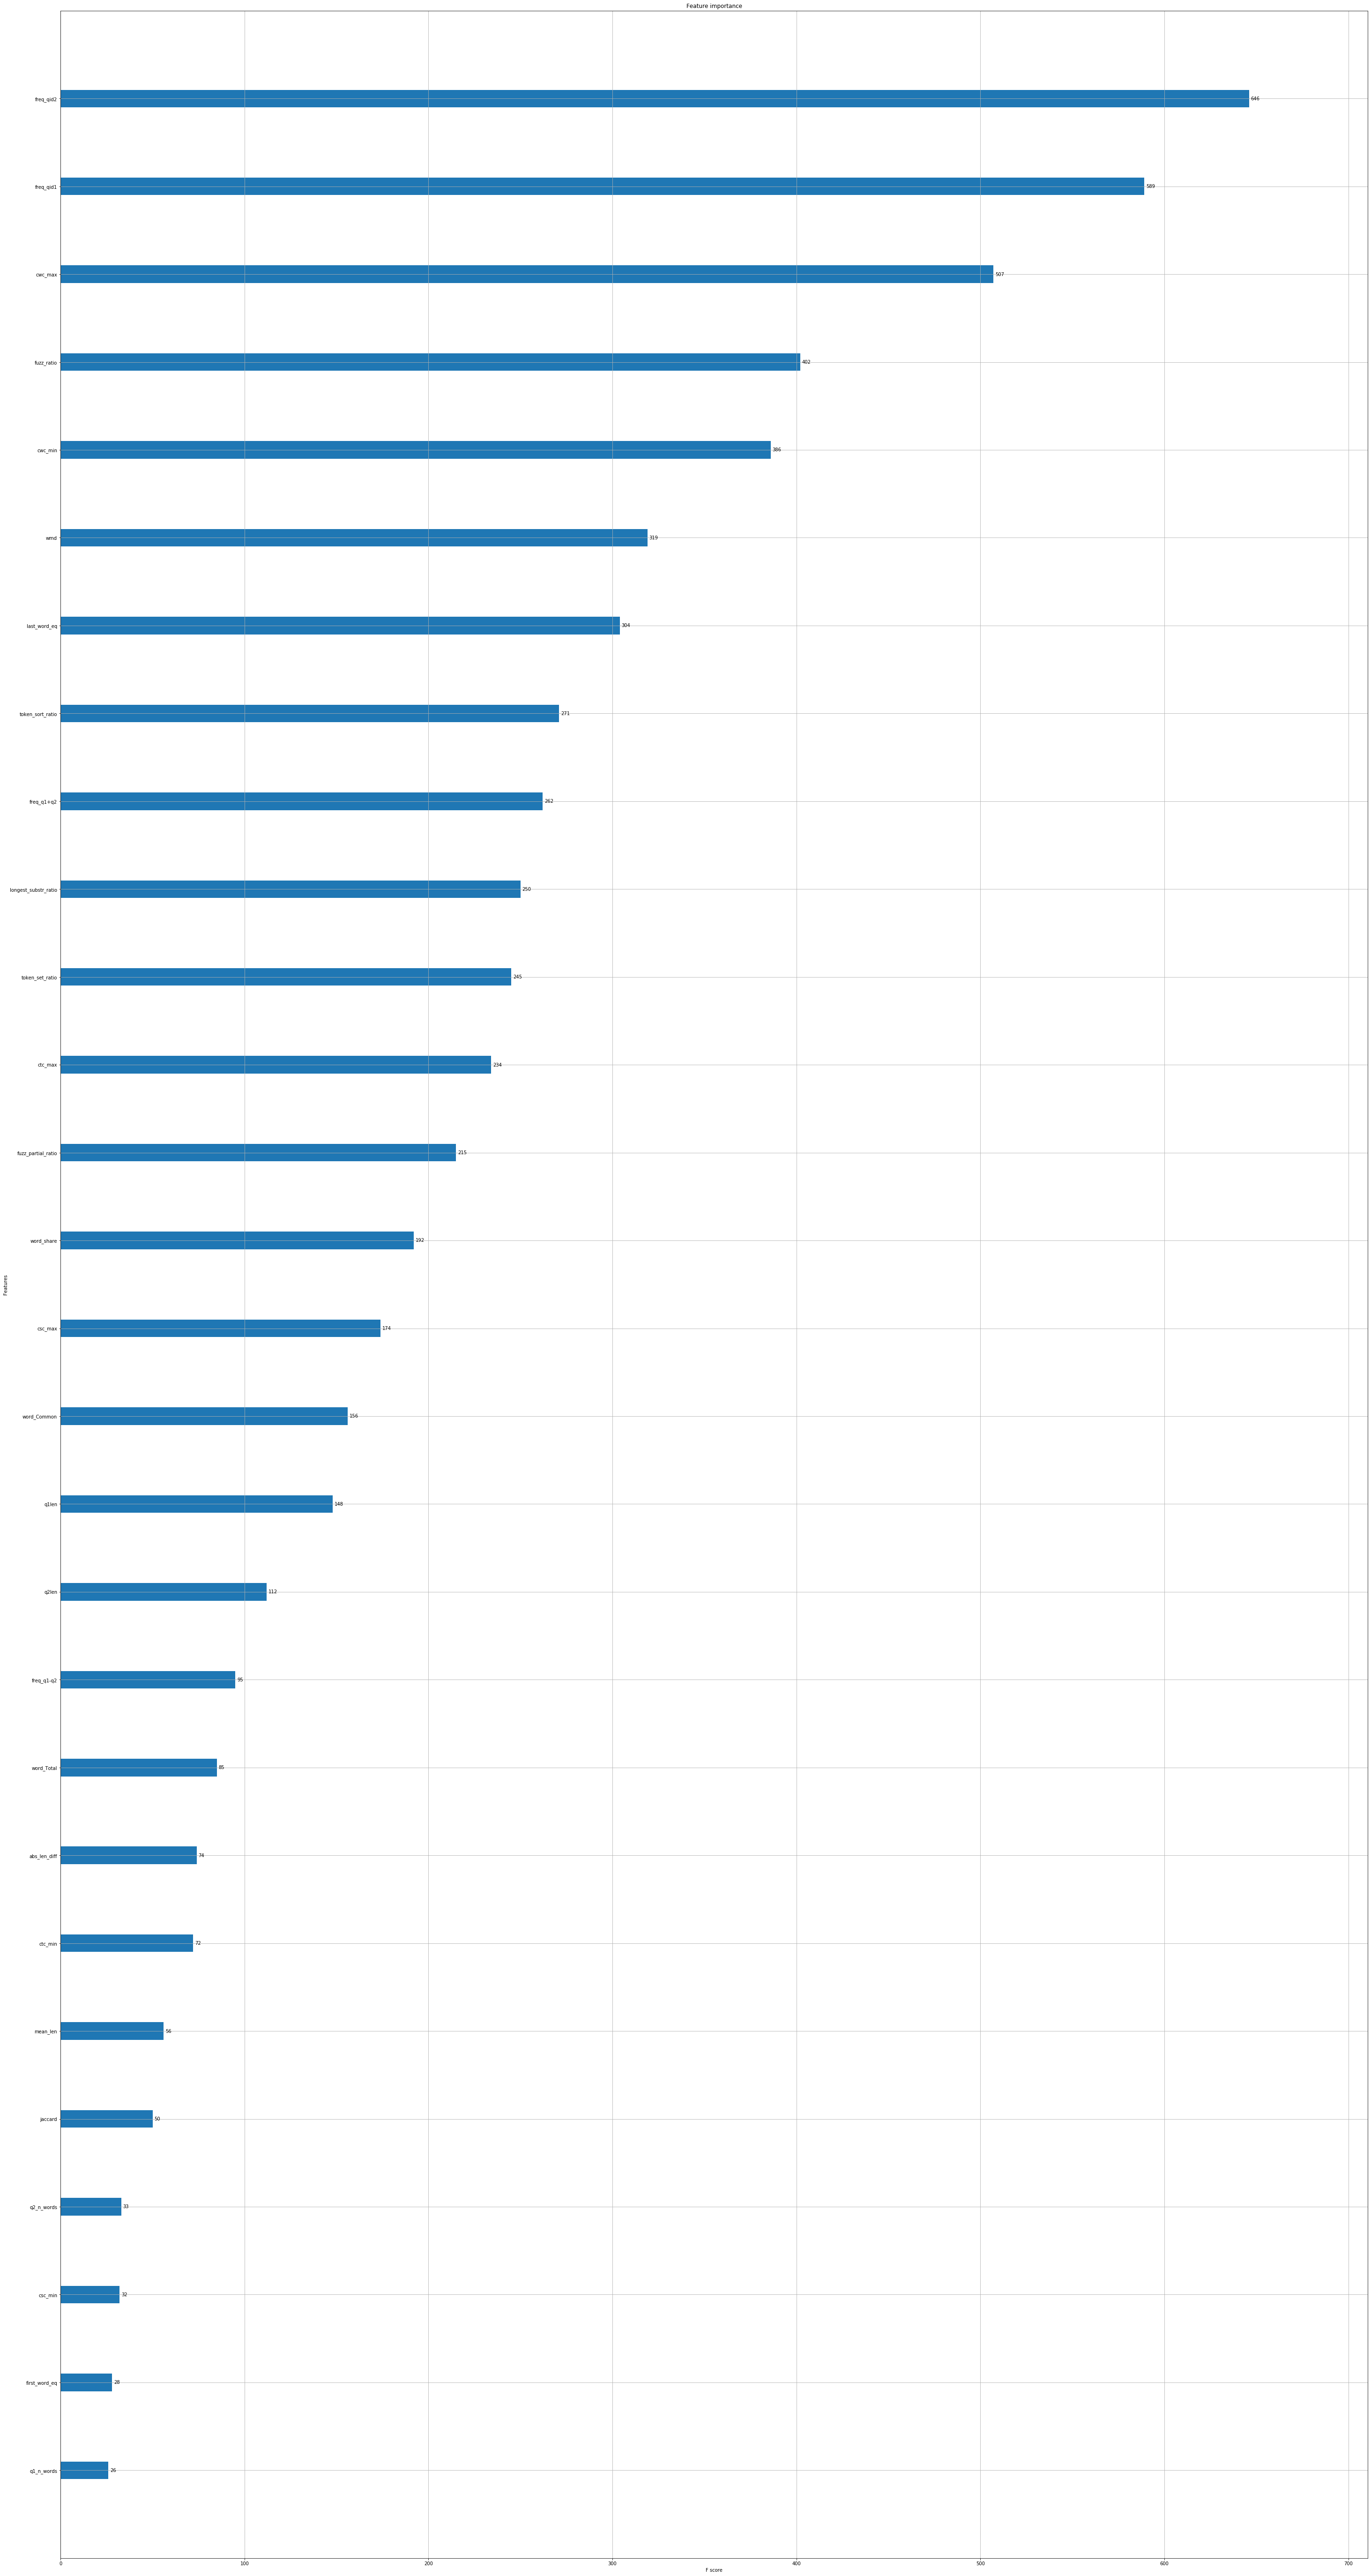

In [36]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 17})
plt.show()

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [38]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

#### Benchmark:

100k Dataset
* 78% without MinMaxScaler
* 81% with MinMaxScaler


400k Dataset
* 83% with MinMaxScaler -> probably this might have worked the same with 150-200k rows


In [42]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     84158
           1       0.79      0.74      0.76     49257

    accuracy                           0.83    133415
   macro avg       0.82      0.81      0.82    133415
weighted avg       0.83      0.83      0.83    133415



In [47]:
res = clf.predict(test[features_list])

In [49]:
test['is_duplicate'] = res

In [ ]:
test.to_csv('data/xgb_classifier_test.csv',index=False)

In [ ]:
test[['test_id','is_duplicate']].to_csv('data/1st_submission.csv',index=False)

If you have an AMD Graphic Card but still want to work with neural nets and Keras you might want to use [PlaidML](https://github.com/plaidml/plaidml), think abuot it like CUDA for AMD ( Doesn't work for RNN )

**Sources:**
* [Detecting duplicate questions on Quora- beating Stanford's accuracy](https://medium.com/data-science-101/detecting-duplicate-questions-on-quora-beating-stanfords-accuracy-6f18b3634d06)
* [Original Notebook](https://colab.research.google.com/drive/1M95Ccrf0lhzyModrMQWQZoho8h-OngSy#scrollTo=SO2GRdB6CVDf)
* [Identifying duplicate questions on Quora | Top 12% on Kaggle!](https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30)
* [Universal Sentence Encoder Large V5](https://aihub.cloud.google.com/u/0/p/products%2F42c1bfd4-8104-450c-a348-29b047d3691c)

In [61]:
%%capture --no-display
import keras.layers as layers
from keras.models import Model
from keras import backend as K
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [62]:
%%capture --no-display
import tensorflow as tf
import tensorflow_hub as hub

In [46]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [63]:
DROPOUT = 0.1

def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

def create_model():
    # Taking the question1 as input and ceating a embedding for each question before feed it to neural network
    q1 = layers.Input(shape=(1,), dtype=tf.string)
    embedding_q1 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q1)
    # Taking the question2 and doing the same thing mentioned above, using the lambda function
    q2 = layers.Input(shape=(1,), dtype=tf.string)
    embedding_q2 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q2)

    # Concatenating the both input layer
    merged = layers.concatenate([embedding_q1, embedding_q2])
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    # Normalizing the input layer,applying dense and dropout  layer for fully connected model and to avoid overfitting 
    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    # Using the Sigmoid as the activation function and binary crossentropy for binary classifcation as 0 or 1
    merged = layers.BatchNormalization()(merged)
    pred = layers.Dense(2, activation='sigmoid')(merged)
    model = Model(inputs=[q1,q2], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X1 = train['question1']
X2 = train['question2']
y = train['is_duplicate']
# Using the sklearn to split data in question1 and question2 train and test in the ration 80-20 %
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

train_q1 = X1_train.tolist()
train_q1 = np.array(train_q1, dtype=object)[:, np.newaxis]
train_q2 = X2_train.tolist()
train_q2 = np.array(train_q2, dtype=object)[:, np.newaxis]

train_labels = np.asarray(pd.get_dummies(y_train), dtype = np.int8)

test_q1 = X1_test.tolist()
test_q1 = np.array(test_q1, dtype=object)[:, np.newaxis]
test_q2 = X2_test.tolist()
test_q2 = np.array(test_q2, dtype=object)[:, np.newaxis]

test_labels = np.asarray(pd.get_dummies(y_test), dtype = np.int8)


In [64]:
nn_model = create_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 512)          0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 512)          0           input_12[0][0]                   
__________________________________________________________________________________________________
concatenat

In [66]:
from keras.callbacks import ModelCheckpoint

# Creating the tensorflow session to train the model and save checkpoint after every epoch.
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    filepath="models/model-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    callbacks_list = [checkpoint]
    history = nn_model.fit([train_q1, train_q2], 
            train_labels,
            validation_data=([test_q1, test_q2], test_labels),
            epochs=10,
            batch_size=512, callbacks=callbacks_list)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 791s 10ms/step - loss: 0.5869 - acc: 0.6979 - val_loss: 0.7746 - val_acc: 0.4983
Epoch 2/10
 3072/80000 [>.............................] - ETA: 8:59 - loss: 0.4848 - acc: 0.7728

KeyboardInterrupt: 

In [69]:
q1 = input("Type Question 1 here -->")
q2 = input("Type Question 2 here -->") 
q1 = np.array([[q1],[q1]])
q2 = np.array([[q2],[q2]])
# Using the same tensorflow session for embedding the test string
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    # Loading the save weights
    nn_model.load_weights('models/model-01-0.50.hdf5')  
    # Predicting the similarity between the two input questions 
    predicts = nn_model.predict([q1, q2], verbose=0)
    predict_logits = predicts.argmax(axis=1)
    print("----FINAL RESULT----")
    if(predict_logits[0] == 1):
        print("****Questions are Similar****")
    else:
        print("****Questions are not Similar****")

Type Question 1 here --> how are you
Type Question 2 here --> are you alright


----FINAL RESULT----
****Questions are not Similar****
